#### The demo codes in this notebook are based on Knet VAE <a href="https://github.com/denizyuret/Knet.jl/tree/master/examples/variational-autoencoder"> example</a> by (c) Deniz Yuret, 2019.

#### (c) Burak Acar, 2021 (acarbu@boun.edu.tr)


#### Resources
* <a href="https://arxiv.org/abs/1312.6114">Auto-Encoding Variational Bayes</a> by Diederik P Kingma, Max Welling
* <a href="https://arxiv.org/abs/1606.05908"> Tutorial on Variational Autoencoders </a> Carl Doersch
* <a href="https://arxiv.org/abs/1701.00160">GAN Tutorial</a> by Ian Goodfellow and its <a href="https://www.youtube.com/watch?v=HGYYEUSm-0Q"> video</a>


### Generative Models

The core of machine learning lies in learning the data distribution, $P_{data}(y,\mathbf{x})$,  which is almost always unobservable. By means of building a parametric model of this distribution and optimizing the model parameters such that it fits to the *limited* observed data, we try to make estimates when a new data sample arrives. The model we build represents that distribution somehow. 

Generative models take a more direct approach to this problem. It refers to any model that tries to learn a representation of $P_{data}(y,\mathbf{x})$. Essentially, the output is an explicit or an implicit probability distribution, $P_{model}(y,\mathbf{x})$.

Goodfellow lists 5 reasons of using generative models. Quoting from his tutorial:
* "Training and sampling from generative models is an excellent test of our ability to represent and manipulate high-dimensional probability distributions."
* "Generative models of time-series data can be used to simulate possible futures....Generative models can be incorporated into (model-based) reinforcement learning."
* "Generative models can be trained with missing data and can provide predictions on inputs that are missing data. One particularly interesting case of missing data is semi-supervised learning, in which the labels for many or even most training examples are missing."
* "Generative models,..., enable machine learning to work with multi-modal outputs.... can produce multiple different correct answers."
* "...realistic generation of samples from some distribution."

<u>It may be fair, if not over-rated, to say that the generative models allow us to *create* data/samples that have never been observed, or even do not exist.</u>

Generative models can be divided into two main categories. The models that explicitly learn a model distribution $P_{model}(y,\mathbf{x})$ to approximate $P_{data}(y,\mathbf{x})$. Their outputs are distributions. On the other hand, the models that implicitly learn a model distribution, learn to draw samples from $P_{model}(y,\mathbf{x})$ that approximates $P_{data}(y,\mathbf{x})$. Their outputs are generated samples. A taxonomy of generative models can be given as follows:

<center>
<img src="https://drive.google.com/uc?id=1firkzrdBs4NA39QCOeuAXXC-ADrXTIb8" alt="Generative Models" width="500"/>
</center>

<!--
<img src="GenerativeModels.png" width="500"/>
-->

Image <a href="https://arxiv.org/abs/1701.00160">source</a>

In these lecture notes, we will be talking about the most popular examples of each group, namely the *Variational Auto-Encoiders* and the *Generative Adversarial Networks*.

### Variational Auto-Encoders

Let,
* $\mathbf{x} \in \mathcal{X}$ be the data,
* $(\mathbf{z} \in \mathcal{Z}) \sim P(\mathbf{z})$ be a multivariate latent random variable,
* $f_\theta(\mathbf{z}): \mathcal{Z} \times \Theta \rightarrow \mathcal{X}$ be a parametric deterministic function, which itself is a random process as  $\mathbf{z}$ is a random variable.

The generative model underlying the VAEs, which has roots in *Maximum Likelihood*, aims at maximizing

$
\begin{eqnarray}
P(\mathbf{x}_1,...,\mathbf{x}_N) & = & \int P(\mathbf{x}_1,...,\mathbf{x}_N|\mathbf{z};\theta)P(\mathbf{z})d\mathbf{z}\\
P(\mathbf{X})                    & = & \int \underbrace{P(\mathbf{X}|\mathbf{z};\theta)}_{f_\theta(\mathbf{z})}P(\mathbf{z})d\mathbf{z} \hspace{1cm}\star\\
\end{eqnarray}
$

So, if we knew $P(\mathbf{z})$ and had powerful function estimator, then we should be able to *learn a function*, ie. $f_\theta(\mathbf{z})$, that maximizes the likelihood of our data, ie $P(\mathbf{X})$. Even then, the two challenges here are,
1. How to define the latent variable $\mathbf{z}$, ie. define what it captures and how it is distributed?
2. How to compute the integral in $\star$?

VAEs have solutions to these 2 challenges...

* **The Latent Space: $P(\mathbf{z}) ...$**

It is not an easy task to construct the latent space, yet alone estimate the distribution. We'd rather *learn* them. That's what VAEs do. They assert that the samples $\mathbf{z}$ can be drawn from a simple, yet continuous distribution, such as $\mathcal{N}(0,\mathbf{I})$, and a parametric random variable tranformer can be learned (recall pdf transformations from your probability courses...) that maps 

$\mathbf{z} \sim \mathcal{N}(0,\mathbf{I}) \xrightarrow{g_\alpha(.)} \hat{\mathbf{z}} \sim P(\hat{\mathbf{z}})$

followed by a second parametric function that maps

$\hat{\mathbf{z}} \xrightarrow{h_\beta(.)} \mathcal{X}$

Then, let us put these two into a single map as

$\mathbf{z} \sim \mathcal{N}(0,\mathbf{I}) \xrightarrow{f_\theta(\mathbf{z})=h_\beta(g_\alpha(\mathbf{z}))} \mathcal{X} \sim \mathcal{N}(f_\theta(\mathbf{z}),\sigma^2\mathbf{I})$

$f_\theta(\mathbf{z})$ is the parametric decoder that we will learn. Deep neural networks are sufficiently powerful models to approximate this mapping.

* **The Likelihood Integral in $\star$**

The brute force, and irrational, approach would be to draw many samples from $P(\mathbf{z})=\mathcal{N}(\mathbf{z};0,\mathbf{I})$ and estimate the expected value of $f_\theta(\mathbf{z})$'s. But instead, it would be more efficient if we could sample $\mathcal{Z}$ such that $P(\mathbf{X}|\mathbf{z};\theta)$ is high. 

This calls for $Q(\mathbf{z}|\mathbf{X})$, ie another parametric function (a distribution) that tells us which $\mathbf{z}$'s are more likely to generate good data via $f_\theta(\mathbf{z})$. Note that $Q(\mathbf{z}|\mathbf{X})$ looks like an encoder, $\mathcal{X}\rightarrow\mathcal{Z}$, hence the name.

* **The Loss: What Do We Learn?**

Recall that we are after maximizing $P(\mathbf{X})$. Then we need to establish the relation between $\mathbb{E}_{\mathbf{z}\sim Q(\mathbf{z})}\{P(\mathbf{X}|\mathbf{z})\}$ and $P(\mathbf{X})$. **This is critical!**

Recall that we can measure the similarity between two distributions using Kullback-Leibler Divergence ($\mathcal{D}$) as

$\mathcal{D}\left\{Q(\mathbf{z})||P(\mathbf{z}|\mathbf{X})\right\}=\mathbb{E}_{\mathbf{z}\sim Q(\mathbf{z})}\left\{log(Q(\mathbf{z}))-log(P(\mathbf{z}|\mathbf{X}))\right\}$

via Bayes Theorem $P(\mathbf{z}|\mathbf{X})=\frac{P(\mathbf{X}|\mathbf{z})P(\mathbf{z})}{P(\mathbf{X})}$

$
\begin{eqnarray}
\mathcal{D}\left\{Q(\mathbf{z})||P(\mathbf{z}|\mathbf{X})\right\}&=&\mathbb{E}_{\mathbf{z}\sim Q(\mathbf{z})}\left\{log(Q(\mathbf{z}))-log(P(\mathbf{X}|\mathbf{z}))-log(P(\mathbf{z}))+log(P(\mathbf{X}))\right\}\\
             &=&\mathbb{E}_{\mathbf{z}\sim Q(\mathbf{z})}\left\{log(Q(\mathbf{z}))-log(P(\mathbf{X}|\mathbf{z}))-log(P(\mathbf{z}))\right\}+log(P(\mathbf{X}))\\
log(P(\mathbf{X}))-\mathcal{D}\left\{Q(\mathbf{z})||P(\mathbf{z}|\mathbf{X})\right\}&=& -\mathbb{E}_{\mathbf{z}\sim Q(\mathbf{z})}\left\{log(Q(\mathbf{z}))-log(P(\mathbf{X}|\mathbf{z}))-log(P(\mathbf{z}))\right\}\\
             &=&\mathbb{E}_{\mathbf{z}\sim Q(\mathbf{z})}\left\{-log(Q(\mathbf{z}))+log(P(\mathbf{X}|\mathbf{z}))+log(P(\mathbf{z}))\right\}\\
             &=&\mathbb{E}_{\mathbf{z}\sim Q(\mathbf{z})}\left\{log(P(\mathbf{X}|\mathbf{z}))\right\}-\mathbb{E}_{\mathbf{z}\sim Q(\mathbf{z})}\left\{log(Q(\mathbf{z}))-log(P(\mathbf{z}))\right\}\\
log(P(\mathbf{X}))-\mathcal{D}\left\{Q(\mathbf{z})||P(\mathbf{z}|\mathbf{X})\right\}&=&\mathbb{E}_{\mathbf{z}\sim Q(\mathbf{z})}\left\{log(P(\mathbf{X}|\mathbf{z}))\right\}-\mathcal{D}\left\{Q(\mathbf{z})||P(\mathbf{z})\right\}
\end{eqnarray}
$

If we choose $Q(\mathbf{z})$ to be conditioned on $\mathbf{X}$ and set $Q(\mathbf{z}|\mathbf{X})=P(\mathbf{z}|\mathbf{X})$ then KL-divergence on the left will be zero and we will be left with $log(P(\mathbf{X}))$ which we want to maximize to start with. So, we get to maximize (the gain),

$
log(P(\mathbf{X})) = \mathbb{E}_{\mathbf{z}\sim Q(\mathbf{z})}\{log(\underbrace{P(\mathbf{X}|\mathbf{z})}_{Decoder})\}-\mathcal{D}\{\underbrace{Q(\mathbf{z}|\mathbf{X})}_{Encoder}||P(\mathbf{z})\}
$, s.t. $Q(\mathbf{z}|\mathbf{X})=P(\mathbf{z}|\mathbf{X})\wedge P(\mathbf{z})=\mathcal{N}(\mathbf{z};0,\mathbf{I})\hspace{0.5cm}\star\star$

* **Optimization via some form of SGD**

Choosing to use Gaussian distributions, we need the gradient of

$
\begin{eqnarray}
J(\alpha,\beta)=J(\theta)&=&\mathbb{E}_{\mathbf{z}\sim Q(\mathbf{z})}\{log(\underbrace{P(\mathbf{X}|\mathbf{z})}_{Decoder:\\ \mathcal{N}(\mathbf{X};f_\alpha(\mathbf{z}),\Sigma)})\}-\mathcal{D}\{\underbrace{Q(\mathbf{z}|\mathbf{X})}_{Encoder:\\ \mathcal{N}(\mathbf{z};\mu_\beta(\mathbf{X}),\Sigma_\beta(\mathbf{X}))}||\mathcal{N}(\mathbf{z};0,\mathbf{I})\}\\
                         &=&\mathbb{E}_{\mathbf{z}\sim Q(\mathbf{z})}\{log(\mathcal{N}(\mathbf{X};f_\alpha(\mathbf{z}),\Sigma))\}-\mathcal{D}\{\mathcal{N}(\mathbf{z};\mu_\beta(\mathbf{X}),\Sigma_\beta(\mathbf{X}))||\mathcal{N}(\mathbf{z};0,\mathbf{I})\}\\
\hat{J}(\theta)&=&\underbrace{log(\mathcal{N}(\mathbf{X};f_\alpha(\mathbf{z}),\Sigma))}_{\hat{J}_1(\alpha)}-\underbrace{\mathcal{D}\{\mathcal{N}(\mathbf{z};\mu_\beta(\mathbf{X}),\Sigma_\beta(\mathbf{X}))||\mathcal{N}(\mathbf{z};0,\mathbf{I})\}}_{\hat{J}_2(\beta)}\star\star\star\\                         
\frac{\partial \hat{J}}{\partial \theta} &=&  \frac{\partial }{\partial \alpha} log(\mathcal{N}(\mathbf{X};f_\alpha(\mathbf{z}),\Sigma))-\frac{\partial }{\partial \beta} \mathcal{D}\{\mathcal{N}(\mathbf{z};\mu_\beta(\mathbf{X}),\Sigma_\beta(\mathbf{X}))||\mathcal{N}(\mathbf{z};0,\mathbf{I})\} \\
\\
\hat{J}_2(\beta)=\mathcal{D}\{\mathcal{N}(\mathbf{z};\mu_\beta(\mathbf{X}),\Sigma_\beta(\mathbf{X}))||\mathcal{N}(\mathbf{z};0,\mathbf{I})\}&=&\frac{1}{2}\left(trace(\Sigma_\beta(\mathbf{X}))+\mu_\beta^T(\mathbf{X})\mu_\beta(\mathbf{X})-k-log(det(\Sigma_\beta(\mathbf{X})))\right)\hspace{0.5cm}\mbox{ k is the dimension of latent variable}\\
\hat{J}_1(\alpha)&=&log(\mathcal{N}(\mathbf{X};f_\alpha(\mathbf{\hat{z}}),\Sigma))\hspace{0.5cm}\mbox{given}  
\hspace{0.5cm}\mathbf{\hat{z}}=\mu_\beta+\Sigma_\beta^{1/2}\mathbf{z}\hspace{0.2cm}\mbox{ & }
\hspace{0.5cm}\mathbf{z}\sim\mathcal{N}(\mathbf{z};0,\mathbf{I})\\
&&\mbox{: This reparametrization is the r.v. transformer, we use to facilitate backpropagation}\\
&&\mbox{: Further}\\
\hat{J}_1(\alpha)&\sim&-||\mathbf{x}-f_\alpha(\mathbf{\hat{z}})||^2 \mbox{ because Normal Dist is maximized @ its mean}\\
&&\mbox{ so this loss function attains the same optimum.}
\end{eqnarray}
$

Maximize $\hat{J}_1(\alpha)-\hat{J}_2(\beta)$. i.e. maximize $\hat{J}_1(\alpha)$ and minimize $\hat{J}_2(\beta)$.

PS: The figure below lacks the minus sign in $\hat{J}_1(\alpha)$, without the minus sign, $\hat{J}_1 + \hat{J}_2 $ below is to be minimized.

<center>
<img src="https://drive.google.com/uc?id=1pdgt9-KcQCHc1v5QIksJCkTPYNmjoa8C" alt="VAE" width="400"/>
</center>

<!--
<img src="vae.png" width="400"/>
-->

Image <a href="https://arxiv.org/abs/1606.05908"> source </a>. In the figure, replace $\mathbf{z}$ with $\mathbf{\hat{z}}$ and $\epsilon$ with  $\mathbf{z}$ for notational consistency.

In plain English, 
* The *Encoder* generates the latent variable ($\mathbf{z}$) distribution which is assumed to be Gaussian from which the input ($\mathbf{x}$) is likely to be drawn.
* $\hat{J}_1$ is for the Decoder training and it drives the learning process for the Encoder as a regularizer. Recall that we could have used $\mathbf{z}\sim \mathcal{N}(\mathbf{z};0,\mathbf{I})$ and skip the encoding. But then, we would have to draw high number of samples to properly sample the data space and train the Decoder via $\hat{J}_1$. Instead, we used the training data to drive the sampling from the data space, forcing it to different segments of the data space as determined by the training samples. That's the trick we used to write Equation $\star\star$.
* The *Decoder* generates a sample ($\mathbf{x}$) based on a given latent variable ($\mathbf{z}\sim \mathcal{N}(\mathbf{z};\mu_\beta(\mathbf{X}),\Sigma_\beta(\mathbf{X}))$). To facilitate backpropagation, the *sampling* step is left out of the backpropagation path by means of a simple trick. We sample from $\mathcal{N}(\mathbf{z};0,\mathbf{I})$, which is NOT parametric, instead of $\mathcal{N}(\mathbf{z};\mu_\beta(\mathbf{X}),\Sigma_\beta(\mathbf{X}))$, which is parametric. The parameters are left in the backpropagation path.
* $\hat{J}_2$ is for the Encoder training and it drives the learning process for the Decoder as a regularizer. 

<br>
<br>

* **Testing**

VAEs have a peculiar position when it comes to testing. Afterall, we learn to generate samples that look like real samples but are not real samples, all driven by a random process. 

As a viable option,  we can run the encoder to get $\mathcal{N}(\mu(\mathbf{x}),\Sigma(\mathbf{x}))$ and draw a number of samples from this distribution, decode them and evaluate the right-hand side of Equation $\star\star$. Note that the right-hand side of Equation $\star\star$ defines a lower bound for $log(P(\mathbf{x}))$ which is achieved if $Q(\mathbf{z}|\mathbf{X})=P(\mathbf{z}|\mathbf{X})$. The further away from it, the better the model is. 

We sample the $\mathcal{N}(\mu(\mathbf{x}),\Sigma(\mathbf{x}))$ but not $\mathcal{N}(\mathbf{z};0,\mathbf{I})$ because it is expected to converge to true distribution faster (with less drawings).

Or else, we can choose to design the performance assessment with regard to the underlying goal of training a VAE, such as data augmentation.

In [41]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200


In [ ]:
device = 'cpu' # My computer does not have CUDA

In [ ]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

In [ ]:
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

In [43]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1) # turn 4D x into a 2D matrix s.t. A x B x C x D -> ABC x D
        x = F.relu(self.linear1(x))  # MLP with relu - Hidden layer
        return self.linear2(x)

In [44]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 784)

    def forward(self, z):
        z = F.relu(self.linear1(z)) # MLP with relu - Hidden layer
        z = torch.sigmoid(self.linear2(z)) # MLP with relu followed by MLP with sigm
        return z.reshape((-1, 1, 28, 28)) # Sigmoid is used to limit the output to 0-1

In [45]:
# TO SEE HOW WE'D MAKE AN AUTOENCODER FUNCTION
# class Autoencoder(nn.Module):
#     def __init__(self, latent_dims):
#         super(Autoencoder, self).__init__()
#         self.encoder = Encoder(latent_dims)
#         self.decoder = Decoder(latent_dims)

#     def forward(self, x):
#         z = self.encoder(x)
#         return self.decoder(z)

In [46]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc # hack to get sampling on the GPU
        self.N.scale = self.N.scale
        self.kl = 0

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [48]:
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(1,epochs+1):
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
            loss.backward()
            opt.step()
        if (epoch %5 == 0) | (epoch ==1):
            print("Epoch: ", epoch, ", Mean Loss: ", loss/epoch)
    return autoencoder

In [49]:
data_train = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data',
               transform=torchvision.transforms.ToTensor(),
               train=True,
               download=True),
        batch_size=100,
        shuffle=True)

data_test = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data',
               transform=torchvision.transforms.ToTensor(),
               train=False,
               download=True),
        batch_size=100,
        shuffle=True)

In [50]:
latent_dims = 2

vae = VariationalAutoencoder(latent_dims).to(device) # GPU

vae = train(vae, data_train)

Epoch:  1 , Mean Loss:  tensor(4288.5776, grad_fn=<DivBackward0>)
Epoch:  5 , Mean Loss:  tensor(757.4081, grad_fn=<DivBackward0>)
Epoch:  10 , Mean Loss:  tensor(391.8130, grad_fn=<DivBackward0>)
Epoch:  15 , Mean Loss:  tensor(236.9356, grad_fn=<DivBackward0>)
Epoch:  20 , Mean Loss:  tensor(192.4293, grad_fn=<DivBackward0>)


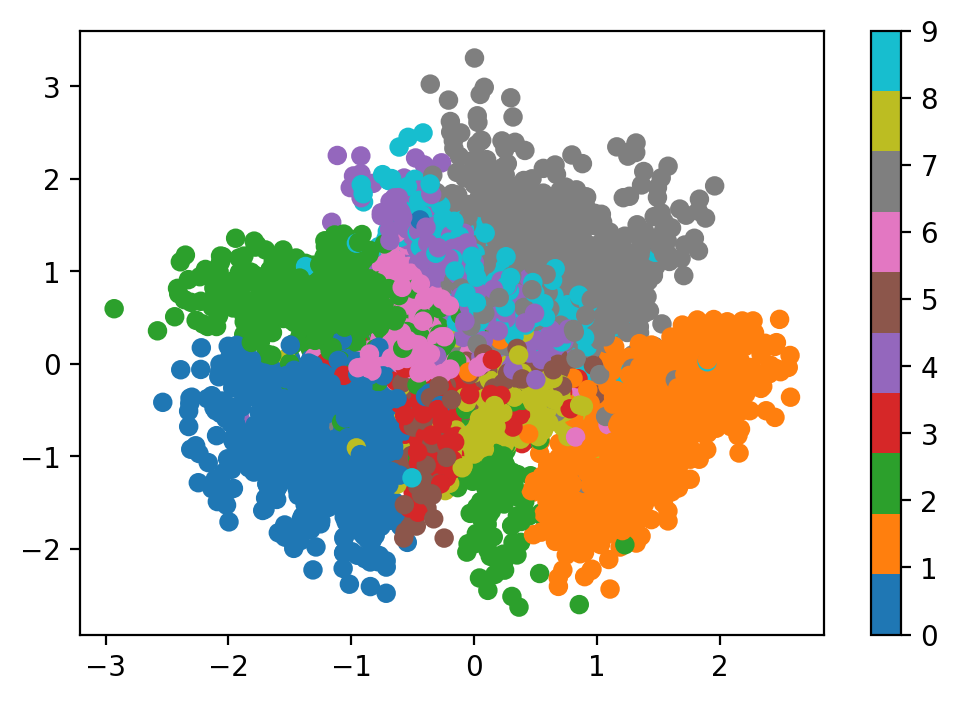

In [53]:
plot_latent(vae, data_train)

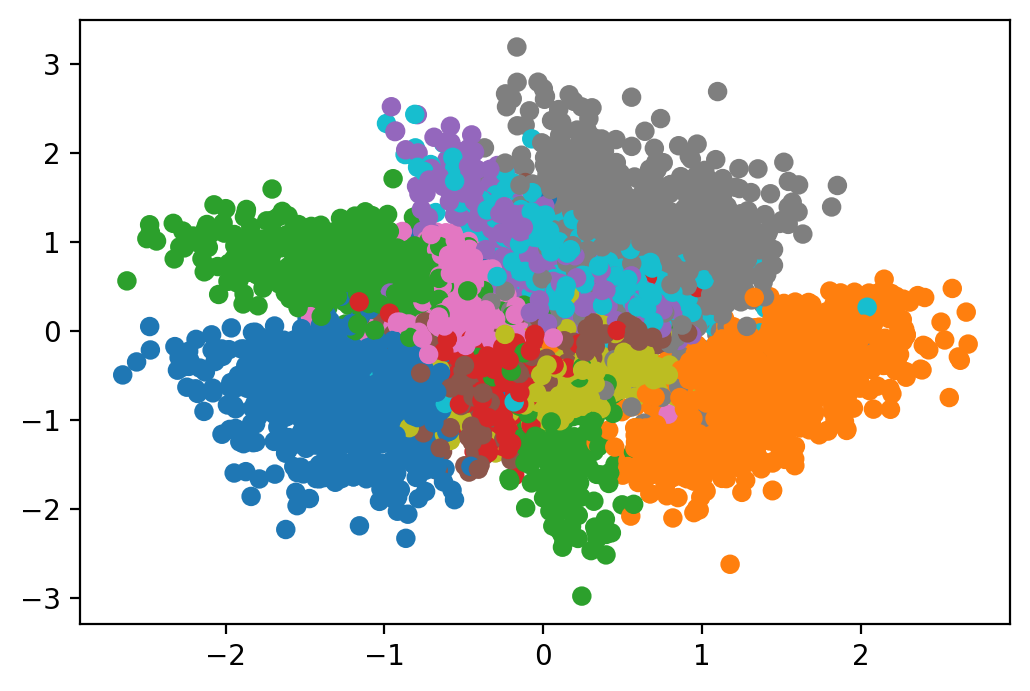

In [54]:
plot_latent(vae, data_test)

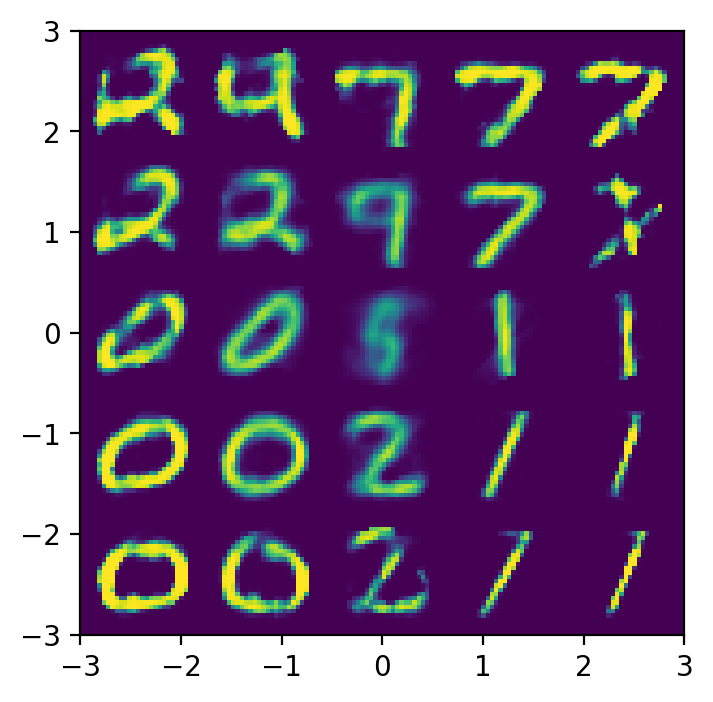

In [55]:
plot_reconstructed(vae, r0=(-3, 3), r1=(-3, 3),n=5)